# Assignment 2
This section will introduce how we have structured our answers to the second assignment in the course *Social graphs and interactions* (02805). 

Each of the 5 parts can be found as heading and is marked as `Part x:`. Furthermore, have each of the assignments for each part been marked with **bold** letters. We have also added a `Part 0` that shortly addresses how the graph, that will be used, has been created.

On a handfull of ocations we have printed the chosen data structures. This is to give more transparancy in how we have structured the data. The notebook is kept in *scroll mode* so they easily can be ignored if the reader desires so.

In the cell below can a list of all libraries that have utilized be seen as they are imported. Moreover, a seed is set to ensure the reproducibility of the results. Please also note that $\log()$ refers to the natural logarithm. With these remarks - let's get hacking ;-)

<img src="https://img.youtube.com/vi/KEkrWRHCDQU/0.jpg" alt="image info" />

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pickle
import powerlaw
import nltk
import itertools
import wordcloud

from community import community_louvain
from operator import itemgetter

# Nice plots and graphs

import seaborn as sns; sns.set()
%matplotlib inline

# Ignore warnigns (only used for final output)
import warnings
warnings.filterwarnings("ignore")

# Use seed for reproducability
np.random.seed(42)

# Part 0: Getting the Graph

For this assignment, it is assumed that the network of superheroes has already been generated. However, for the interested reader, this section will summarize in words how the network was generated.


1. The superheroes from Marvel and DC were loaded as data frames using the provided link
    1. Marvel: https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/marvel_characters.csv
    2. DC: https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2020/master/files/dc_characters.csv
2. The data was processed i.e. NA rows were removed and duplicate superhero names removed. The universe was assigned to the two data frames. As well as removing Dorling Kindersley from the frame as it is not a superhero but a publisher.
3. The two data frames were combined into one the wiki link was split into two columns. One for the raw wikilink and one for the section on the Wikipedia page if the superhero did not have a designated page but only a section on another Wikipedia page.
4. When each row of the data frame was used to access every superhero Wikipedia page (if they had one) or their section if they only had a section on a different Wikipedia page.
5. Every page text was examined in a raw/unformatted format in a dictionary with a superhero as a corresponding key. Such that link was marked as [[*LINK*]].
6. Every page´s formatted text was additionally stored `super_hero_dict_formatted.pickle` as a dictionary with a superhero as a corresponding key for text analysis.
7. Based on the dictionary an adjacency matrix was created.
    1. The adjacency matrix was initialized as a zero matrix with the same number of rows and columns (i.e. a square matrix) as the length of the number of superheroes. Such that the first superhero corresponds to the first row and column.
    2. When every superhero's unformatted Wikipedia page was examined by looking up in the dictionary.
    3. The links to other Wikipedia pages were extracted using regular expressions.
    4. If there was a link to another superhero the corresponding column was set equal to 1.
8. Based on the adjacency matrix the undirected graph for all superheroes were created and stored as `full_graph_directed.pickle`
9. In this graph the universe and length of Wiki-article were added as attributes for the nodes.
10. Based on the directed graph the giant connected component was extracted and made undirected. That graph was stored as `GCC_undirected.pickle`. 



The notebook that contains the source code utilized to generate the superhero graph and dictionary with the formatted Wikipedia articles can be found by accessing the following link: https://nbviewer.jupyter.org/github/MikkelGroenning/social_graph/blob/main/Assignment2/part_0.ipynb. It has been generated with dependencies described in the environment file https://github.com/MikkelGroenning/social_graph/blob/main/environment.yml. 

(Note the notebook is pretty raw and short on comments. This has not been prioritized as it that not part of the assignment. But the interested reader can view how it was specifically generated by reading the code.)


If there is a desire to play around with the dataset in the loaded as pickles they are publicly available at https://github.com/MikkelGroenning/social_graph/tree/main/Assignment2/Data. 

The directed fully connected graph, the fully connnected undirected graph and formatted wikipidea articles are now loaded in notebook. 

In [2]:
# Full directed graph
comic_graph = nx.read_gpickle('Data/full_graph_directed.pickle')

# Read undirected graph based on GCC
GCC_undirected = nx.read_gpickle("Data/GCC_undirected.pickle")

# Wiki pages
super_hero_dict = pickle.load( open( "Data/super_hero_dict_formatted.pickle", "rb" ) )

# Create subgraph for Marvel and DC universe 
G_marvel = GCC_undirected.subgraph([superhero for superhero, universe in nx.get_node_attributes(GCC_undirected, 'Universe').items() if universe == 'Marvel'])
G_dc = GCC_undirected.subgraph([superhero for superhero, universe in nx.get_node_attributes(GCC_undirected, 'Universe').items() if universe == 'DC'])

# Part 1: Visualization and Statistics of the Network

In this part of the assignment, the directed giant connected component will be examined. This can be accessed by considering the fully directed graph stored in the variable `comic_graph`. The function `weakly_connected_components` from the `networkx` library is utilized to extract the giant connected component considering there only needs one directed edge in one direction for considering two nodes to be connected.

In [3]:
# Extract the weakly connected components
con_comp = max(nx.weakly_connected_components(comic_graph), key = len)

# Define GCC
comic_graph_GCC = comic_graph.subgraph(con_comp).copy()

## Part 1a: Basic Statistics of the Network

Firstly some basic statistics are investigated using `Networkx` and Python in general.

**What is the number of nodes in the network?**

This is calculated with the `.nodes` method as follows:

In [4]:
N = len(comic_graph_GCC.nodes())
print('The network consists of', N ,'nodes.')

The network consists of 2593 nodes.


If one checked the raw data files one could see that there are a bit more than 3000 super heroes. But as the GCC has been extracted some are *lost* leading to the result of 2593.

**What is the number of links?**

Here, the `.edges` method are utilized:

In [5]:
L = len(comic_graph_GCC.edges())
print('The network consists of', L ,'edges.')

The network consists of 24975 edges.


So around 10 times more edges and as such it can be deducted that the average degree is around 20. Let's have a closer look at the edges.

**What is the number of links connecting Marvel and DC? Explain what those links mean?**

In [6]:
# Extract node lists from each universe
marvel_nodes = [superhero for superhero, univserse in nx.get_node_attributes(comic_graph_GCC, 'Universe').items() if univserse == 'Marvel']
dc_nodes = [superhero for superhero, univserse in nx.get_node_attributes(comic_graph_GCC, 'Universe').items() if univserse == 'DC']

# Initialize lists
num_of_links_between_marvel_dc = []
num_of_links_between_dc_marvel = []

# Populate lists
for marvel_node, dc_node in zip(marvel_nodes, dc_nodes):
    
    # Calculate the number of links between the Marvel node and the DC nodes.
    edges_from_marvel_node = list(dict(comic_graph_GCC[marvel_node]).keys())
    num_of_links_from_marvel_node_to_dc_nodes = sum([edge in dc_nodes for edge in edges_from_marvel_node])
    num_of_links_between_marvel_dc.append(num_of_links_from_marvel_node_to_dc_nodes)
    
    # Calculate the number of links between the DC node and the Marve nodes.
    edges_from_dc_node = list(dict(comic_graph_GCC[dc_node]).keys())
    num_of_links_from_dc_node_to_marvel_nodes = sum([edge in marvel_nodes for edge in edges_from_dc_node])
    num_of_links_between_dc_marvel.append(num_of_links_from_dc_node_to_marvel_nodes)
    
# Print result
print('There are', sum(num_of_links_between_marvel_dc), 'edges from the Marvel universe to the DC universe.')
print('There are', sum(num_of_links_between_dc_marvel), 'edges from the DC universe to the Marvel universe.')

There are 338 edges from the Marvel universe to the DC universe.
There are 468 edges from the DC universe to the Marvel universe.


The network consist of a total of 2593 nodes and 24975 edges. However, only 338 edges goes to DC nodes from a Marvel node. Vice versa only 468 edges gores to Marvel nodes from DC nodes. This is a total of 806 which is only around 1/30 of the total edges in the graph. This, from the result above, it is clear that there is only a few edges that connect the two universes.

**Who are top 5 most connected characters? (Report results for in-degrees and out-degrees).**

Let's explore the five superheros with highest in-degree:

In [7]:
top5_in = dict(sorted(dict(comic_graph_GCC.in_degree).items(), key = itemgetter(1), reverse = True)[:5])
top5_in

{'Superman': 589,
 'Batman': 574,
 'Spider-Man': 479,
 'Captain America': 430,
 'Iron Man': 355}

The 5 superheroes with the largest in-degree are by most people instantly recognizable. They are the most popular superheroes and have been along for a long. More specifically 
* Superman was created in 1938, 
* Batman was created in  1938,
* Spider-Man was created in  1962,
* Captain America was created in  1940, and
* Iron Man was created in 1963. 
[source: wiki ;-) ]

All the above superheroes stars in their very own comic books series. In contrast, the less popular superheroes are introduced as sidekick or villain in the same comic books. It, therefore, makes sense that these old guys have so many references to other superheroes.


Let's explore the five superheros with highest out-degree:

In [8]:
top5_out = dict(sorted(dict(comic_graph_GCC.out_degree).items(), key = itemgetter(1), reverse = True)[:5])
top5_out

{'Barracuda (II)': 67,
 'Belthera, Queen': 59,
 'Deathstroke': 59,
 'Butcher': 54,
 'Venom': 52}

These super heroes requies a more trained superhero enthusiast to recognize. It's not clear why they have a high out-degree. However, if one investiages the length of the Wikipedia articles it's clear that these superheros have long articles. 

In [9]:
for super_hero in top5_out.keys():
    print(super_hero, ': Wikipidea article consists of ', comic_graph_GCC.nodes[super_hero]['length_of_content'], 'words.') 

Barracuda (II) : Wikipidea article consists of  13893 words.
Belthera, Queen : Wikipidea article consists of  9709 words.
Deathstroke : Wikipidea article consists of  12739 words.
Butcher : Wikipidea article consists of  5208 words.
Venom : Wikipidea article consists of  19744 words.


This is compared to the mean number of words for all superheros displayed in the cell below. It can be seen the superheros with high out degree have long wikipedia articles compared to the average.

In [10]:
# Print average
np.array([comic_graph_GCC.nodes[node]['length_of_content'] for node in comic_graph_GCC.nodes]).mean()

2820.431932124952

This leads to a suspecion, that there is a relationship between the length of the Wikipidea article and the number of refences to other superheros. In the cell below a plot is genearted which diplays a scatter plot that shows the relationship between the number of links to other superheros a Wikipedia articles refers to, and the length of that particular article.

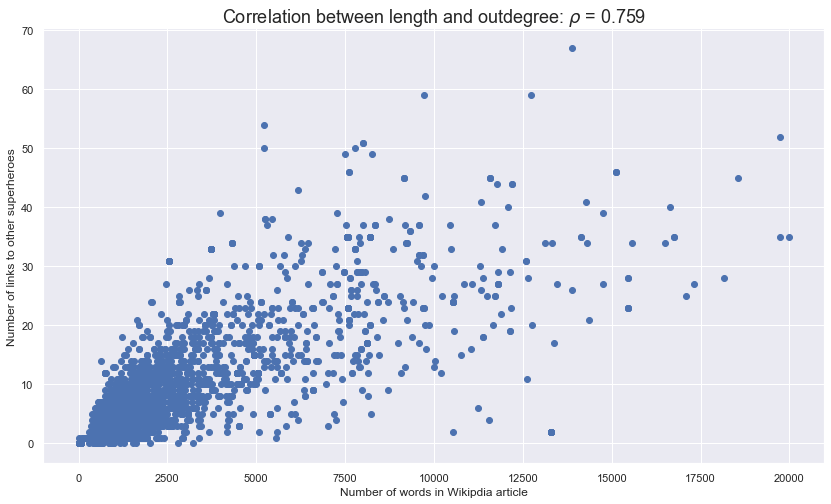

In [11]:
# Lists of length and out degree
LEN = [comic_graph_GCC.nodes[node]['length_of_content'] for node in comic_graph_GCC.nodes]
OD = [v for k,v in comic_graph_GCC.out_degree]

# Correlation coefficient
rho = np.corrcoef(LEN, OD)[1,0]

# Plot
plt.figure(figsize = (14,8))
plt.scatter(LEN,OD)
plt.title(fr'Correlation between length and outdegree: $\rho$ = {rho:.3f}', fontsize = 18)
plt.ylabel('Number of links to other superheroes')
plt.xlabel('Number of words in Wikipdia article')
plt.show()

The correlation is clearly seen and the correlation coefficients between the length of the wiki-pages and the number of links to other superheroes is found to 0.759, which is fairly high and very significant given the number of observations.

**Plot the in- and out-degree distributions.**
Now the distributions of the in- and out-degree of the nodes are investigated.

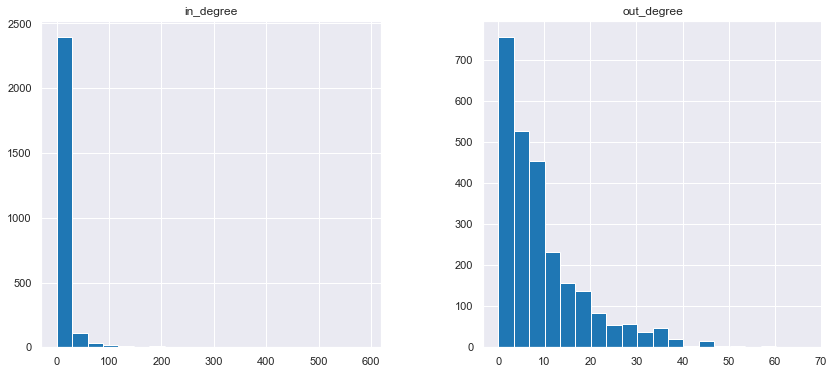

In [12]:
# Store in and out degree in datafram
degree_distribution = pd.DataFrame({
    'in_degree' : np.array(list(dict(comic_graph_GCC.in_degree).values())),
    'out_degree' : np.array(list(dict(comic_graph_GCC.out_degree).values()))
})

# Illustrate results
hist = degree_distribution[['in_degree', 'out_degree']].hist(bins=20, figsize=(14,6), color = "tab:blue")

This is very clearly not the same distribution (note the differenct axis). This look like something that would be worth exploring in log-log plot which is done below:

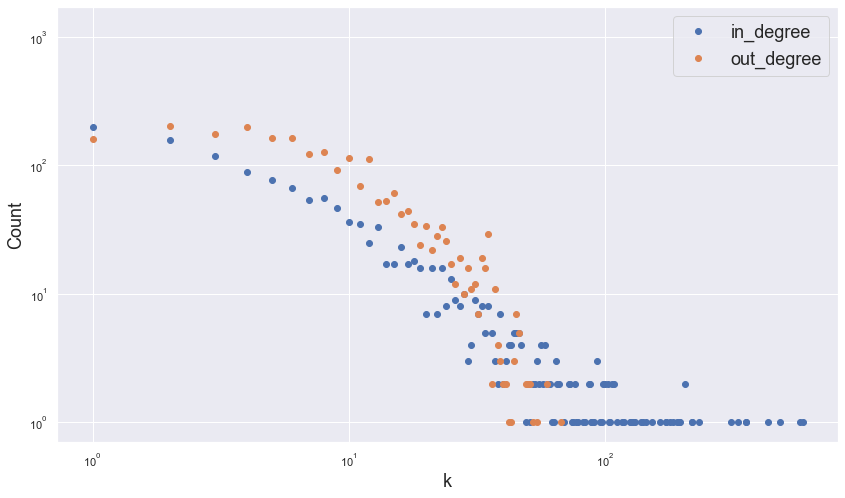

In [13]:
# Initialize plot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (14,8))
degree_distribution['in_degree'].value_counts().to_frame().plot(style='o', ax = ax1)
degree_distribution['out_degree'].value_counts().to_frame().plot(style='o', ax = ax1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("k", fontsize = 18)
ax1.set_ylabel("Count", fontsize = 18)
ax1.legend(fontsize = 18)
plt.show()

Indeed the log-log plot revails more information about the difference in distribution between in and out degree. From the plot it appear as the *in degree* distribution acts scale free whereas the the *out degree* distribution act more random. This hypothesis can be explored further by investigating exponent of the degree distribution using the `powerlow` library.

In [14]:
# Calculate exponent
in_degree_exponent = powerlaw.Fit(degree_distribution.in_degree.values, verbose = False).alpha
out_degree_exponent = powerlaw.Fit(degree_distribution.out_degree.values, verbose = False).alpha

# Print results
print('In degree exponent : ', round(in_degree_exponent, 3))
print('Out degree exponent : ', round(out_degree_exponent, 3))

In degree exponent :  2.354
Out degree exponent :  11.298


As expected the in degree distribution resmaple a Scale-free network as $2 < \gamma_{in} = 2.354 < 3$ [1, chap 4.7], whereas the out degree distribution are harder to diagnose. The distribution has a heavy tail but deviate from being scale-free given $\gamma_{out} = 11.298 > 3$.

The reason why different distributions are observed can be compared with a *social network*, where there are some popular super heroes that many *know*. In this case it is those that is often refered to, and as seen above it is some of the older and more famous super heroes.

**Compare the degree distribution to a random network with the same number of nodes and probability of connection $p$.**

To initilize the random network with the same number of nodes and probability of connection the average degree is needed. Though the distribution of in degree and out degree are very different for super hero network the average degree is the same:
$$\langle k_{in} \rangle = \langle k_{out} \rangle$$
This makes good sense good sense as outgoing edge from note is the ingoing edge for another node. This can further be verified by examining the mean of `degree_distribution` dataframe as seen in the cell below. 

In [15]:
degree_distribution.mean()

in_degree     9.631701
out_degree    9.631701
dtype: float64

The average degree of $\langle k_{in}\rangle = 9.631701$, can be utilized to calculate the probability that two nodes are connected. From [1, eq. (3.3)] it is know that $\langle k \rangle = p (N-1)$. In this equation $p$ can be isolated and results in the following expression:
$$p = \frac{\langle k \rangle}{N-1}.$$
As the mean, which is $\langle k \rangle$, in the Poisson distribution is equal $\lambda$ the values can easily be inserted and it this specific case it yields:
$$p = \frac{9.631701}{2593} = 0.0037145.$$

With that number and recalling the GCC contains $N=2593$ nodes we can create the random graph.  

In [16]:
rg = nx.erdos_renyi_graph(n = N, p = 0.003714500964, seed=np.random, directed=True)

Now we can examine the distribution of in and out degree. As expected the two distributions take the form of Posison distribtuion with mean around $9.63$. 

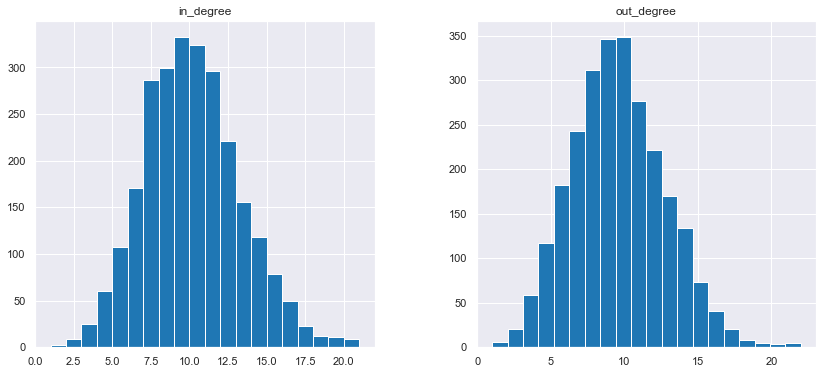

In [17]:
# Store distributions in dataframe
rg_degree_distribution = pd.DataFrame({
    'in_degree' : np.array(list(dict(rg.in_degree).values())),
    'out_degree' : np.array(list(dict(rg.out_degree).values()))
})

# Illustra results
hist = rg_degree_distribution.hist(bins=20, figsize=(14,6), color = "tab:blue")

Now two very similar distributions can be observed - both looks very normal with mean around $\langle k \rangle$. The two graphs, the GCC of super heroes and the random graph, have different distributions which verifies that the super hero graph is **not** a random graph.

## Part 1b: Visualization of the Network


**Create a nice visualization of the total network with the following properties**
  - Color nodes according to universe
  - Scale node-size according to degree
  - Whatever else you feel like.
  - If you can get it to work, get node positions based on the Force Atlas 2 algorithm

In the context of plotting the graph we will consider it undirected as it would anyway be very difficult to see the direction of the edge with so many edges. This can be achived with `to_undirected` method from networkx:

In [18]:
comic_graph_GCC_undirected = comic_graph_GCC.to_undirected()

The different coloring of the two universes can be achived by creating a list with same length as the nodes in the graph. Every element in in the list specifies which color the corrosponding node should take. In the below cell each node is investigated is the node corresponds to a superhero in the Marvel universe the color red is associated with that note whereas the superheros in the DC universe is associated with the color blue. 

In [19]:
# Get node colors
node_colors = ['tab:red' if universe == 'Marvel' else 'tab:blue'  
    for super_hero, universe in nx.get_node_attributes(comic_graph_GCC_undirected, 'Universe').items()]

Like the coloring the size of the nodes can be controlled with a list with the same length of number of nodes. Here each node's degree is looked up and added to the list using a list comprehension. The degree is multiplied with 2 as it gave more pretty plot (found after experiments) as the node with degree of one where pretty difficult to see.

In [20]:
# Get node sizes
node_sizes = [degree*2 for degree in dict(comic_graph_GCC_undirected.degree()).values()]

The edges can be colored with a list the same length as the number of edges. An edge connects two nodes. If the two nodes connected both are from the Marvel uniserse the edge is colored orange. Similar for edges connecting to nodes from the DC universe exepct it is colored cyan. If and edge connect two nodes from both the marvel universe and the DC universe it is colored purple. This achieved by going through every edge in a list comprension and calling the function `color_edge`(defined just below) which find the appropirate color for edge. 

In [21]:
def color_edge(unv1, unv2):
    # Orange for Marvel-Marvel
    if unv1 == 'Marvel' and unv2 == 'Marvel':
        color = 'tab:orange'
    
    # Cyan for DC-DC
    elif unv1 == 'DC' and unv2 == 'DC':
        color = 'tab:cyan'
    
    # Purple for DC-Marvel/Marvel-DC
    else:
        color = 'tab:purple'
        
    return color 

# Get add edges colors
edge_colors = [
    color_edge(*(nx.get_node_attributes(comic_graph_GCC_undirected, 'Universe')[f],
                 nx.get_node_attributes(comic_graph_GCC_undirected, 'Universe')[t]))
    for f, t in comic_graph_GCC_undirected.edges
]

Finally the graph can be plotted with above lists as input to control the size and color. The force atlas algorithm will be ultized to determine the position of nodes. After some experiments 1000 iterations was found to be sufficient without having too long computations times.

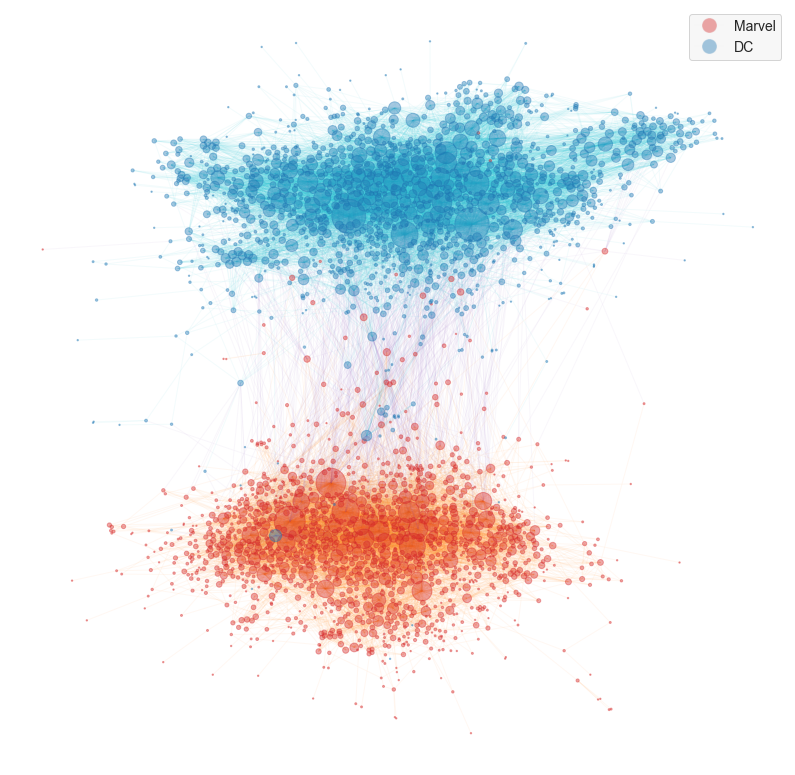

In [22]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    edgeWeightInfluence = 0.5, # Performance

    # Performance
    jitterTolerance=0.2,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,

    # Tuning
    scalingRatio=5.0,
    gravity=1.0,

    # Log
    verbose=False
)

# Initialize
plt.figure(figsize=(14,14))

# Calculate positions
positions = forceatlas2.forceatlas2_networkx_layout(comic_graph_GCC_undirected, pos=None, iterations=1000)

# Draw graph
nx.draw_networkx_nodes(
    G = comic_graph_GCC_undirected,
    node_size = node_sizes,
    pos = positions, 
    node_color=node_colors,
    alpha=0.4
)
nx.draw_networkx_edges(
    G = comic_graph_GCC_undirected,
    pos = positions, 
    edge_color = edge_colors, 
    alpha=0.05
)
plt.axis('off')

# Legend
legend_elements = [Line2D([0], [0], marker='o', color='#F5F5F5', label='Marvel',
                          markerfacecolor='tab:red', markersize=15, alpha=0.4),
                  Line2D([0], [0], marker='o', color='#F5F5F5', label='DC',
                          markerfacecolor='tab:blue', markersize=15, alpha=0.4)]
plt.legend(handles = legend_elements, facecolor = "#F5F5F5", loc=1, fontsize = 14)
plt.show()

"*That looks pretty dope.*" - Group member 2

From the plot of the graph it clear that there are only a few edges that connect the Marvel and the DC universe. Two clear hubs are also seen based on the universes. In both universes, some heroes are very popular. The popular heroes act as hubs in the graph. When examining the color of the nodes it appears as a few nodes a placed "wrong" accordingly to that universe the originates from and some are placed in between. Interestingly it appears as one of the more popular DC characters has "migrated" to the Marvel universe. This is though not investigated further here.

# Part 2: TF-TR

In this part, the TF-TR method will be utilized and used for creating word-clouds that characterizes the two comic-book universes. 

The TF-TR method is a way to weighting words in a text in order to retrieve information about the text. The first part is to calculate the Term Frequency (TF) which is given as the number of times a word occurs in a text. The result of calculating the TF gives the most common words in a text but they are not necessarily the most important ones. Thus, the TF information must be weighted which constitutes the second part of this method. In this part of the assignment, the weighting is done using Term Ratios (TR). For the two universes, the TR for a term $t$ with term frequency $TF_t^{(u)}$, where universe $u \in \{m, d\}$ is defined as 

$$w_t^{(m)} = \frac{TF_t^{(m)}}{TF_t^{(d)}+c}, \quad w_t^{(d)} = \frac{TF_t^{(d)}}{TF_t^{(m)}+c},$$
where $c$ is a constant which ensures the avoidance of division by zero. Besides acting as constant to ensure no division by zero the constant $c$ also help to bring weight to frequently used words with a large ratio between the two universes. This is best explained by an example. Lets consider a hypothetical scenarior we have found the two terms $t_1$ and $t_2$. The first term is seen 10 times in the Marvel universe and 1 time in the DC universe i.e. $TF_{t_1}^{(m)} = 10$, $TF_{t_1}^{(DC)} = 1$. The other term $t_2$ have frequencies $TF_{t_2}^{(m)} = 100$, $TF_{t_1}^{(d)} = 10$. Without the constant $c$ the two ratios are equal i.e.
\begin{align}
    w_{t_1}^{(m)} &= w_{t_2}^{(m)} \\
    \frac{ TF_{t_1}^{(m)} }{ TF_{t_1}^{(d)} } &= \frac{ TF_{t_2}^{(m)} }{ TF_{t_2}^{(d)} } \\
    \frac{10}{1} &= \frac{100}{10}
\end{align}

However, if the constant $c>0$ is introduced the weighting change in the favor of $t_2$ the ratio consiting of larger term frequencies i.e. 
\begin{align}
    \frac{ TF_{t_1}^{(m)} }{ TF_{t_1}^{(d)} + c } < \frac{ TF_{t_2}^{(m)} }{ TF_{t_2}^{(d)} + c}.
\end{align}
With $c >> 0$ the difference in weighting becomes even larger $w_{t_2}^{(m)} >> w_{t_2}^{(m)}$. The constant $c$ acts as sort of regularizer as ratios consisting of small word frequencies becomes small and ratios consiting of large word frequencies becomes larger. This help bring more "meaningfull" word forward from each universe rather than words with have large ratio. When appling this sort weigting  it is assumed that the universes have a comparable number of words.

With this, a TF-TR list for each universe can be created where the ranking of term $t$ in universe $u$ is given by $TF_t^{(u)} \times w_t^{(u)}$.

These lists will then be used for creating the so-called TF-TR word-clouds.

**Create your own version of the TF-TR word-clouds. Explain your process and comment on your results.**

Using the dictionary containing all superheroes in both universes with corresponding wiki-texts, two lists are created for separating the universes.  

In [23]:
# Make lists of wikitext for both universes
marvel_list = []
dc_list = []

# Populate lists
for super_hero in super_hero_dict:
    if super_hero_dict[super_hero]['Wiki_text'] != None: # Pass if no wikitext is found
        
        # Fill Marvel
        if super_hero_dict[super_hero]['Universe'] == 'Marvel':
            marvel_list.append(super_hero_dict[super_hero]['Wiki_text'])  
        
        # Fill DC
        elif super_hero_dict[super_hero]['Universe'] == 'DC':
            dc_list.append(super_hero_dict[super_hero]['Wiki_text'])

Each wiki-text in the universe are tokenized into individual strings using the `RegexpTokenizer`. This tokenizer ensures that all punctuation are removed from the texts. In addition, every word is set to lower case. 

In [24]:
# Tokenize the pages into individual strings and remove all punctuation from the list of tokens
tokenizer = nltk.RegexpTokenizer(r'\w+')

# Apply to the lists of words from both universes
tokens_marvel = tokenizer.tokenize(" ".join([i for i in marvel_list if i is not None]).lower())
tokens_dc = tokenizer.tokenize(" ".join([i for i in dc_list if i is not None]).lower())

The term frequency of each word is calculated using the `nltk.FreqDist`-function. It outputs a dictionary-like strucutre with the words as keys and the corresponding values are the number of times each term occurs. This is similar to doing a raw count of each word. 

In [25]:
# Term frequency for both universes
TF_marvel = nltk.FreqDist(tokens_marvel)
TF_dc = nltk.FreqDist(tokens_dc)

When creating the TF-TR the full list of unique words are first found. The formula can then be applied. The TF-TR lists are created as dictionaries with words as keys, and the constant $c$ is set to 50, as this was found to be a reasonable compromise to get some interesting wordclouds. 

In [26]:
# Union the words from both universes
words = set(TF_marvel.keys()).union(set(TF_dc.keys()))

# Initilize dicts
TF_TR_marvel = {}
TF_TR_dc = {}

# Set constant c
c = 50

# Populate dicts
for word in words:
    TF_TR_marvel[word] = (TF_marvel[word])/(TF_dc[word] + c)
    TF_TR_dc[word] = (TF_dc[word])/(TF_marvel[word]+ c)

The TF-TR word-clouds is now created using the `wordcloud` package. It accepts dictionaries as inputs where the values are interpreted as weight - exactly as desired. The clouds are colored with the color themes of the universes. I.e. the DC cloud is blue and the Marvel cloud is red. 

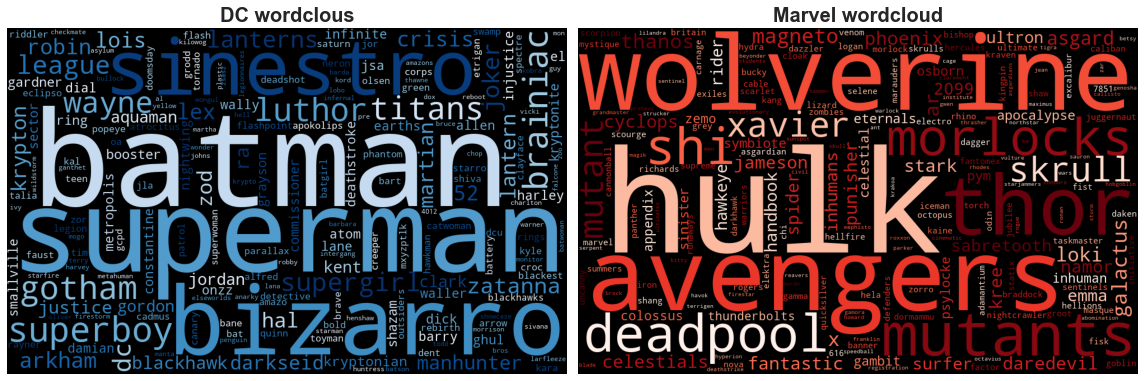

In [27]:
# Initialize plot
fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize = (16,20))

# DC cloud
word_cloud_dc = wordcloud.WordCloud(
    colormap = 'Blues',
    background_color = 'black',
    random_state = 2,
    width = 1000,
    height = 618
)
word_cloud_dc.generate_from_frequencies(TF_TR_dc)
plt.subplot(1, 2, 1)
plt.imshow(word_cloud_dc)
plt.axis('off')
plt.title('DC wordclous', fontsize = 20, fontweight='bold')

# Marvel cloud
word_cloud_marvel = wordcloud.WordCloud(
    colormap = 'Reds',
    background_color = 'black',
    random_state = 2,
    width = 1000,
    height = 618
)
word_cloud_marvel.generate_from_frequencies(TF_TR_marvel)

# Plot them side by side
plt.subplot(1, 2, 2)
plt.imshow(word_cloud_marvel)
plt.axis('off')
plt.title('Marvel wordcloud', fontsize = 20, fontweight='bold')

plt.show()

From the word-clouds, it is seen that some of the important words in the DC universe are Batman, Bizarro, and Superman, etc. This is consistent with what you probably associate the DC universe with. Likewise, some of the important words in the Marvel universe are Wolverine, Hulk, and Morlocks. In general, it is seen that the words that pop up are characters from the respective universes. This indicates how the wiki pages primarily *talks* about characters from their own universe. It is though also seen that some classic superheroes are missing - or at least very small. An example is Spider Man who is one of the most famous superheroes. The *issue* for him is that his name consists of two words and they are thus split by the tokenizer into *spider* and *man*. If one knows examples like these it can be added to the tokenizer to keep them but this has not been investigated further.

# Part 3: Communities and TF-IDF

In this part, the structure of the graph will be investigated closer by looking at *communities* of the data. The optimal partition will be found using the *Louvain method*. Afterward, these communities will be considered as once entity, and their wikitext will be treated as a single *document*. Based on this they can be characterized based on the TF-IDF, where the collection of documents based on the communities are the corpus.

**Find the communities. Explain briefly how you chose to identify the communities: Which algorithm did you use, how does it work?**

In part 3 and 4 only the Marvel universe will be considered by using the `G_marvel` graph why the communities of this universe will be found. This partition will be found with the Louvain method. The algorithm works by iteratively going through the two following steps:

1) All nodes in the network are assigned to their own individual community. For all nodes, $i$ the change in modularity is calculated when the node $i$ is moved into its neighbor $j$'s community. This is done for all neighbors of $i$ and $i$ is then moved into the community that leads to the greatest increase in modularity. If the modularity can not be increased $i$ stays. If no *merge* can lead to increased modularity the algorithm terminates.

2) All nodes that now have become a community are merged into one node. The links between nodes in that community are made into self-loops while weighted links will be used to represent multiple links between a community. On this new graph step 1) can be applied again.

The method is used as it is quite simple to understand. Passing the argument `randomize = False` to the function it also becomes deterministic which is nice for reproducibility. With the `community_louvain.best_partition` function the optimal partition can also be calculated very fast, which is of course also nice.

The partition is calculated below where the output also is shown:

In [28]:
# APply the louvain algorithm
communitiesMarvel = community_louvain.best_partition(G_marvel, randomize = False)

# Show data structure
communitiesMarvel

{'A-Bomb': 0,
 'Abomination': 1,
 'Ajak': 2,
 'Ajax': 2,
 'Amphibius': 3,
 'Anansi': 3,
 'Anelle': 1,
 'Arishem the Judge': 1,
 'Avoe': 1,
 'Brian Banner': 4,
 'Banshee': 5,
 'Barbarus': 3,
 'Baron Blood': 0,
 'Baron Brimstone': 6,
 'Baron Mordo': 7,
 'Baron Strucker': 0,
 'Baron Zemo': 0,
 'Barracuda': 1,
 'Breeze Barton': 4,
 'Bast': 6,
 'Bastion': 5,
 'Batroc the Leaper': 0,
 'Battlestar': 6,
 'Batwing': 4,
 'Beast': 5,
 'Beautiful Dreamer': 5,
 'Bedlam': 3,
 'Beef': 5,
 'Beetle': 3,
 'Belasco': 6,
 'Bella Donna': 6,
 'Bengal': 1,
 'Bereet': 1,
 'Berzerker': 5,
 'Beta Ray Bill': 1,
 'Beyonder': 1,
 'Bi-Beast': 4,
 'Big Bertha': 4,
 'Big Man': 3,
 'Big Wheel': 3,
 'Bird-Man': 6,
 'Bishop': 5,
 'Black Ant': 0,
 'Black Bolt': 1,
 'Black Box': 6,
 'Black Cat': 3,
 'Black Crow': 7,
 'Black Dwarf': 1,
 'Black Jack Tarr': 3,
 'Black Knight': 0,
 'Black Mamba': 6,
 'Black Marvel': 6,
 'Black Panther': 0,
 'Black Racer': 6,
 'Black Rider': 4,
 'Black Spectre': 3,
 'Black Swan': 1,
 'Black Ta

Now, this dictionary is *reversed* so it is possible to easily find the nodes, i.e. superheroes, that belong to a given community. The output is also illustrated:

In [29]:
# Reverse dict
communities_dict = {c: [super_hero for super_hero, community in communitiesMarvel.items() if community == c] 
                    for c in set(communitiesMarvel.values())}

# Show data structure
communities_dict

{0: ['A-Bomb',
  'Baron Blood',
  'Baron Strucker',
  'Baron Zemo',
  'Batroc the Leaper',
  'Black Ant',
  'Black Knight',
  'Black Panther',
  'Blacklash',
  'Blank',
  'Blizzard',
  'Bloodshed',
  'Blue Eagle',
  'Calamity',
  'Capricorn',
  'Carnivore',
  'Challenger',
  'Chemistro',
  'Cheshire Cat',
  'Cobalt Man',
  'Coldblood',
  'Comanche',
  'Conquest',
  'Controller',
  'Crimson Dynamo',
  'Crossbones',
  'Crusher',
  'Darkstar',
  'Deathlok',
  'Detroit Steel',
  'Digitek',
  'Doc Samson',
  'Doctor Spectrum',
  'Dracula',
  'Dreadknight',
  'Dreadnought',
  'Egghead',
  'Enchantress',
  'Falcon',
  'Firepower',
  'Fixer',
  'Flying Tiger',
  'Force',
  'Foxfire',
  'Freak',
  'Friday',
  'Friction',
  'Ghost',
  'Giant-Man',
  'GoGo Tomago',
  'Golden Archer',
  'Goliath',
  'Grasshopper',
  'Griffin',
  'Grim Reaper',
  'Guardsman',
  'Hate-Monger',
  'Haywire',
  'Hermes',
  'Happy Hogan',
  'Hollywood',
  'Honey Lemon',
  'Human Top',
  'Hyperion',
  'Hypnotia',
  'Immo

Let's also have a look at resulting modularity of the partition

In [30]:
nx.algorithms.community.quality.modularity(G_marvel, list(communities_dict.values()))

0.3697382073255283

The ideal modularity is 1 but this is not expected to be seen in a real network. When considering the structure of the network of a single universe - as illustrated in part 1 - it is very connected and it is hard to come by well separated communities. Therefore the modularity of $Q=0.37$ is not as unexpected as the optimal found by the Louvain method.

**How many communities did you find in total?**

This is calculated as the number of elements in the `communities_dict`:

In [31]:
len(communities_dict)

20

A total of 20 communities are found in which there are around 67 nodes on average in a community. The fact that relatively many are found also supports the point stated above where there are not really many well-seperated communities.

**Plot the distribution of community sizes.**

Even though the average of around 67 nodes per community easily is calculated it is interesting to look at the actual distribution of community sizes. This is easily done in a bar plot based on the `communities_dict` where the number of superheroes in a community becomes the height. This is done below:

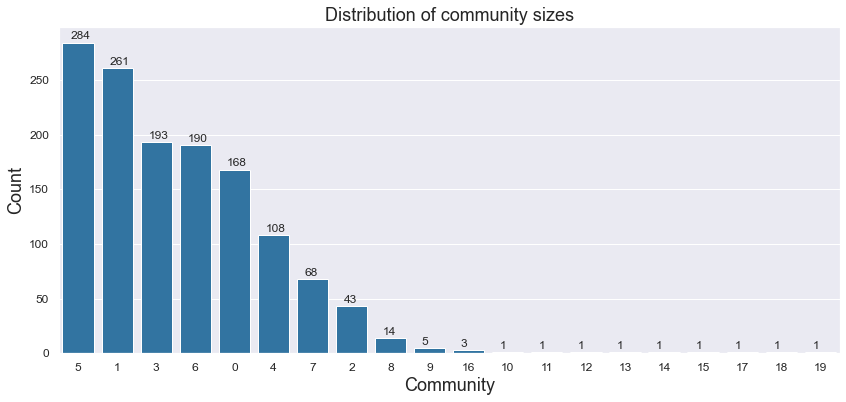

In [32]:
# List to sort according to size
com_size_order = sorted(communities_dict, key = lambda k: len(communities_dict[k]), reverse = True)

# Bar plot
plt.figure(figsize = (14,6))
sns.barplot(
    x = list(communities_dict.keys()), 
    y = [len(com) for com in communities_dict.values()], 
    order = com_size_order,
    color = "tab:blue"
)

# Add counts
for x, count in enumerate(sorted([len(com) for com in communities_dict.values()], reverse = True)):
    plt.text(x-0.2, count + 3 , count, fontsize=12)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel("Community", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
plt.title("Distribution of community sizes", fontsize = 18)
plt.show()

By looking at this plot it is very clear that the distribution is no way near uniform. Some communities end up with more than 250 nodes there is also a handful with very few nodes. Those are pretty difficult to examine the number of heroes in the communities. Therefore the number has been added on top on each bar.

The barplot does not revail the distribution but is rather another informative measure. Thus the histogram of communitity size is also plotted. The y-axis is the number of communities with that given size. The bins are also manually set to widts of 50.

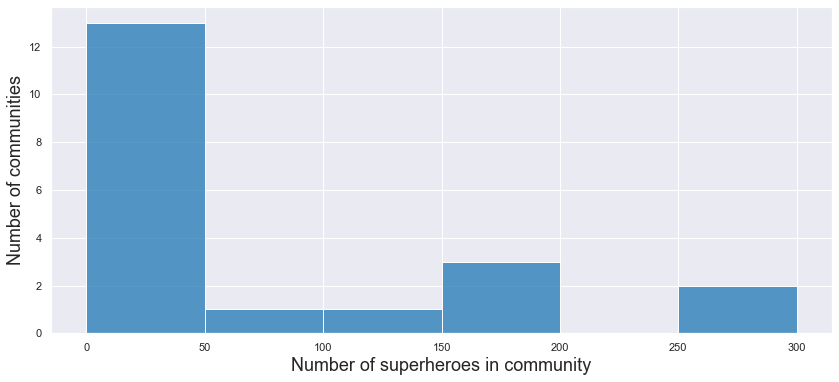

In [33]:
plt.figure(figsize = (14,6))
sns.histplot([len(com) for com in communities_dict.values()], color = "tab:blue",
         bins=range(0, int(np.ceil(max([len(com) for com in communities_dict.values()])/50)*50)+50, 50))
plt.ylabel('Number of communities', fontsize = 18)
plt.xlabel('Number of superheroes in community', fontsize = 18);
plt.show()

From the barplot is apparent that most communities are smaller than 50. From the first plot it is though remembered that 9 communities only consist of 1 node -  which could be isolated nodes. (Notice that isolated nodes can occur since the work only is carried out on the Marvel-subgraph which was extracted from GCC of the entire superhero graph. Thus the Marvel heroes which were only connected to DC superheroes have become isolates). 

The easiest way to inspect the actual structure is by visualizing the communities which are done below. Here, [this list](https://sashamaps.net/docs/resources/20-colors/) is used to get 20 *distinct* colors, where a dictionary that maps from the community to color is defined below. Moreover, the communities with only one node are extracted so these nodes can be emphasized in the plot.

In [34]:
# Color dict from https://sashamaps.net/docs/resources/20-colors/
color_dict = {
    0: '#e6194B', 1: '#3cb44b', 2: '#ffe119', 3:'#4363d8', 4:'#f58231', 5:'#911eb4', 
    6:'#42d4f4', 7:'#f032e6', 8:'#bfef45', 9:'#fabed4', 10:'#469990', 11:'#dcbeff', 
    12:'#9A6324', 13:'#fffac8', 14:'#800000', 15:'#aaffc3', 16:'#808000', 17:'#ffd8b1', 
    18:'#000075',19:'#515151'
}

# Communities with only one node
single_coms = [k for k,v in communities_dict.items() if len(v) == 1]

`ForceAtlas2` is used to illustrate the graph is a very similar fashion as seen in `Part 1` (also with 1000 iterations). All can be seen below function inputs can be seen below.

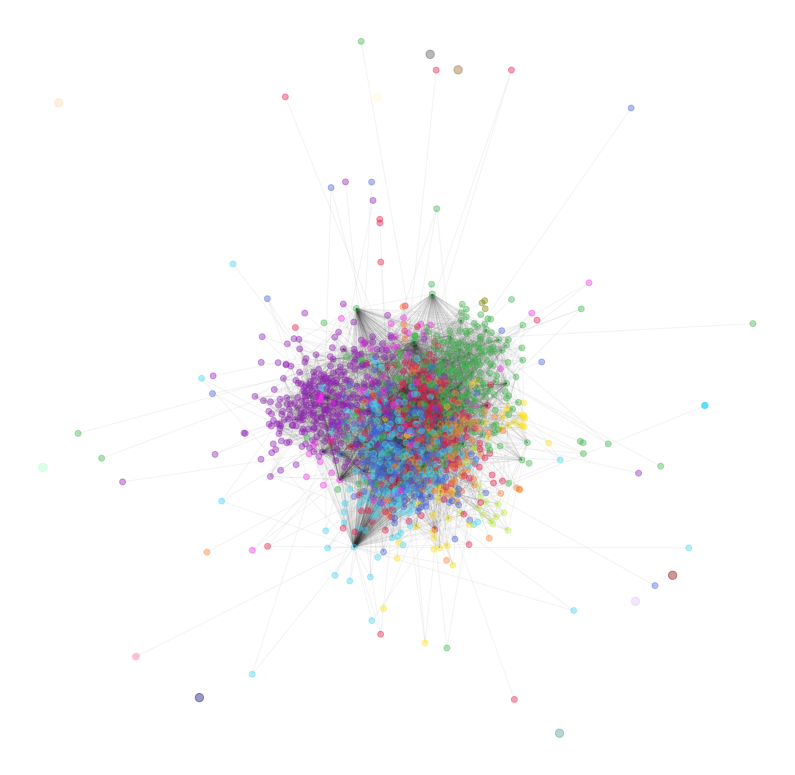

In [35]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    edgeWeightInfluence = 5.5, # Performance

    # Performance
    jitterTolerance=0.2,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,

    # Tuning
    scalingRatio=0.1,
    gravity=1.0,

    # Log
    verbose=False
)

# Calculate positions
positions = forceatlas2.forceatlas2_networkx_layout(G_marvel, pos=None, iterations=1000)
# Find node sizes
node_size = [70 if communitiesMarvel[char] in single_coms else 35 for char in G_marvel.nodes]
# Find node colors
node_color = [color_dict[communitiesMarvel[char]] for char in G_marvel.nodes]

plt.figure(figsize=(14,14))

# Plot nodes
nx.draw_networkx_nodes(
    G = G_marvel,
    node_size = node_size,
    pos = positions, 
    node_color= node_color,
    alpha=0.4
)

# Plot edges
nx.draw_networkx_edges(
    G = G_marvel,
    pos = positions, 
    edge_color = "k", 
    alpha=0.05
)
plt.axis('off')
plt.show()

As there are 20 different communities - and thus 20 different colors - the plot looks kind of messy. Though the plot looks messy there are still some insights. It can be seen that there are 9 nodes in their own community. They are isolates (look after the larger nodes). Moreover, it can also be seen that there is some structure in the colors in the large central cluster with green and purple nodes clearly comes together. To fully understand the communities one should, of course, look closer at the links but due to the size of the network, it will not be investigated further.

**For the 5-10 largest communities, create TF-IDF based rankings of words in each community.**

Now it is time to investigate the communities based on Wikipedia for the superheroes in each community. For this, the 8 largest communities will be used where this number is chosen as there is a cut-off in community sizes from the 8<sup>th</sup> to the 9<sup>th</sup> largest community. From now on the term *document* will refer to the combined wiki-text of all characters in a community and the term *corpus* is the collection of these 8 documents. 

The term frequency-inverse document frequency (TF-IDF) method will be used to describe each community. This leads to words scoring high if they are seen many times in a document but are rare across documents in the corpus. In this case, the *raw count* will be used for the term frequency. The adjustment for the document length is not considered as the later analysis only will look at important words relative to other words in the same document. I.e. TF-IDF values will not be considered between documents and thus normalization would be redundant.

The code below creates all documents by joining all wikitext in each community. The tokenizer from `Part 2` is reused to make all the documents into lists of words. After wards all text was turned to lower case. Please notice that stemming has not been considered here. Afterwards `nltk.FreqDist` is used to count the frequencies of all words in all documents. Dictionaries are used as data structures to keep track of the communities.

In [36]:
# Number of communities to consider
N = 8

# Make all documents
token_dict = {com: tokenizer.tokenize(
                " ".join([super_hero_dict[char]['Wiki_text'] for char in communities_dict[com] 
                if super_hero_dict[char]['Wiki_text'] is not None]).lower()
                ) for com in com_size_order[:N] 
             }

# Calculate the TF
TF_dict = {key: nltk.FreqDist(value) for key, value in token_dict.items()}

The next step is to calculate the inverse document frequency. First, a list of all unique words across the corpus is created called `all_words`. Afterward, the IDF can be calculated as follows:
$$\operatorname{idf}(t, D)=\log \frac{N}{|\{d \in D: t \in d\}|}$$
Here the smoothing versions are not considered as $n_t$ never will be zero, as the list of all words is generated from the documents themselves. The calculation is performed below - again using a dictionary as a data structure.

In [37]:
# List of all words
all_words = set(list(itertools.chain(*token_dict.values())))

# Calculate idf
idf = {key: np.log(N / sum([tf[key] > 0 
            for k, tf in TF_dict.items()])) 
            for key in all_words
      }

With this the tf-idf can now be calculated as follows:
$$\operatorname{tf-idf}(t, d, D)=\operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)$$
A `pandas` data frame is used for this where the rows are the documents (communities) and the columns are all the words. This data frame is then populated by looping over all words and documents.

In [38]:
# Storing TF-IDF in a dataframe
TF_IDF = pd.DataFrame(index = TF_dict.keys(), columns = all_words)

# Populate data frame
for word in TF_IDF.columns:
    for doc in TF_IDF.index:
        TF_IDF.loc[doc, word] = TF_dict[doc][word] * idf[word]     

Let's have a look at the resulting data frame:

In [39]:
TF_IDF

,tubes,schist,stiffen,martin,existences,heist,fn34,popped,deceptively,immobilised,...,biddings,alphanex,ensorcelled,overexcitable,supercomputers,shooters,8th,aragorn,condolence,pitchfork
5,1.41001,0,0,0.534126,2.77259,2.87682,0,0.693147,0,0,...,8.31777,1.41001,0,0,0,0.287682,1.38629,0,2.07944,0
1,0.470004,0,0,0.93472,1.38629,2.58914,0,1.38629,0,2.07944,...,0,1.41001,0.980829,0,1.38629,0.863046,2.07944,2.07944,0,0
3,1.88001,0,0,2.27003,0,4.8906,0,0.693147,0,0,...,0,0,0,0,0,6.61669,0.693147,0,0,5.54518
6,0,4.15888,6.23832,2.27003,0,1.15073,0,1.38629,0,0,...,0,0,0.980829,0,0,1.15073,0,0,0,4.15888
0,0.940007,0,0,1.86944,0,1.43841,4.15888,0,2.07944,0,...,0,0.940007,1.96166,2.07944,0,0.287682,0.693147,1.38629,0,0
4,0.470004,0,0,0.133531,0,0.575364,0,0,0,0,...,0,1.41001,0,0,0,0.575364,0,2.77259,0,0
7,0,0,0,1.06825,0,0,0,0,0,0,...,0,4.70004,0,0,1.38629,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2.07944,0,0


Here it can be seen that the 8 communities are listed as indices with all the words as columns. With around 42.000 words it is hard to fully understand the data. This is the reason why word clouds will be used in a minute. It is though somewhat apparent that words that occur in few documents (many zeros in the columns) have higher values where they appear due to the inverse document frequency.
 

When using tf-idf it is not necessary to explicitly handle stop words as the formula does it by itself. It does this with the idf-part. If a word is found in all documents the idf becomes
$$\operatorname{idf}(t, D)=\log \frac{N}{|\{d \in D: t \in d\}|}=\log \frac{N}{N}=0,$$
thus the tf-idf also becomes 0. Let's look for how many words this is the case:

In [40]:
len([word for word, idf in idf.items() if idf == 0])

3728

So for this many words words the idf is zero since the word appears is all documents. Let's just look at these words:

In [41]:
[word for word, idf in idf.items() if idf == 0]

['concept',
 'robert',
 'soon',
 'prove',
 'into',
 'fled',
 'lacks',
 'unsuccessful',
 'match',
 'enchanted',
 'suit',
 'kind',
 'last',
 'supervillain',
 'grandson',
 'towards',
 'day',
 'hit',
 'cliff',
 'tells',
 'grown',
 'retconned',
 'activity',
 'skills',
 'event',
 'him',
 'firing',
 'insane',
 'start',
 'mixed',
 'john',
 'mentions',
 '100',
 'numbering',
 'returning',
 'talking',
 'savage',
 'crushed',
 'student',
 'lake',
 'potential',
 'convinces',
 'attempts',
 'fang',
 'taylor',
 'wound',
 'bruce',
 'mystically',
 'novels',
 'ears',
 'electromagnetic',
 'forge',
 'tricking',
 'blaming',
 'tony',
 'who',
 'retreats',
 'mutant',
 'gains',
 'demonic',
 'exploded',
 'honor',
 'chief',
 'ship',
 'responsible',
 'effects',
 'direction',
 'where',
 'film',
 'evil',
 'disabled',
 'humanity',
 'rich',
 'entering',
 'title',
 'gradually',
 'truly',
 'puzzle',
 'prison',
 'revamped',
 'howard',
 'lady',
 'cancellation',
 'beams',
 'major',
 'earned',
 'send',
 'sufficiently',
 'ent

So this is very interesting. The td-idf finds the usual stopwords (with, and, the, in etc.) but also more *domain-specific stop words* as fight and vengeance. It may look surprising that all these words are found in all documents but by looking at the lengths of each document (as shown below) it becomes more reasonable.

In [42]:
[len(words) for words in token_dict.values()]

[805663, 590334, 477420, 310667, 371387, 177473, 122650, 77211]

**Create a word-cloud displaying the most important words in each community (according to TF-IDF)**

A word cloud is now created for each document with weights based on the tf-idf. By using the `.to_dict(orient = 'records'))` method on the td-idf data frame dictionaries for each community can easily be extracted and then the word cloud can be generated. (The `wordcloud` package acted buggy in the loop and if it was not imported in the loop it would return the error: *'WordCloud' object has no attribute 'WordCloud'*. A solutions was not found why this atypic code was used). All 8 word clouds are generated and shown below:

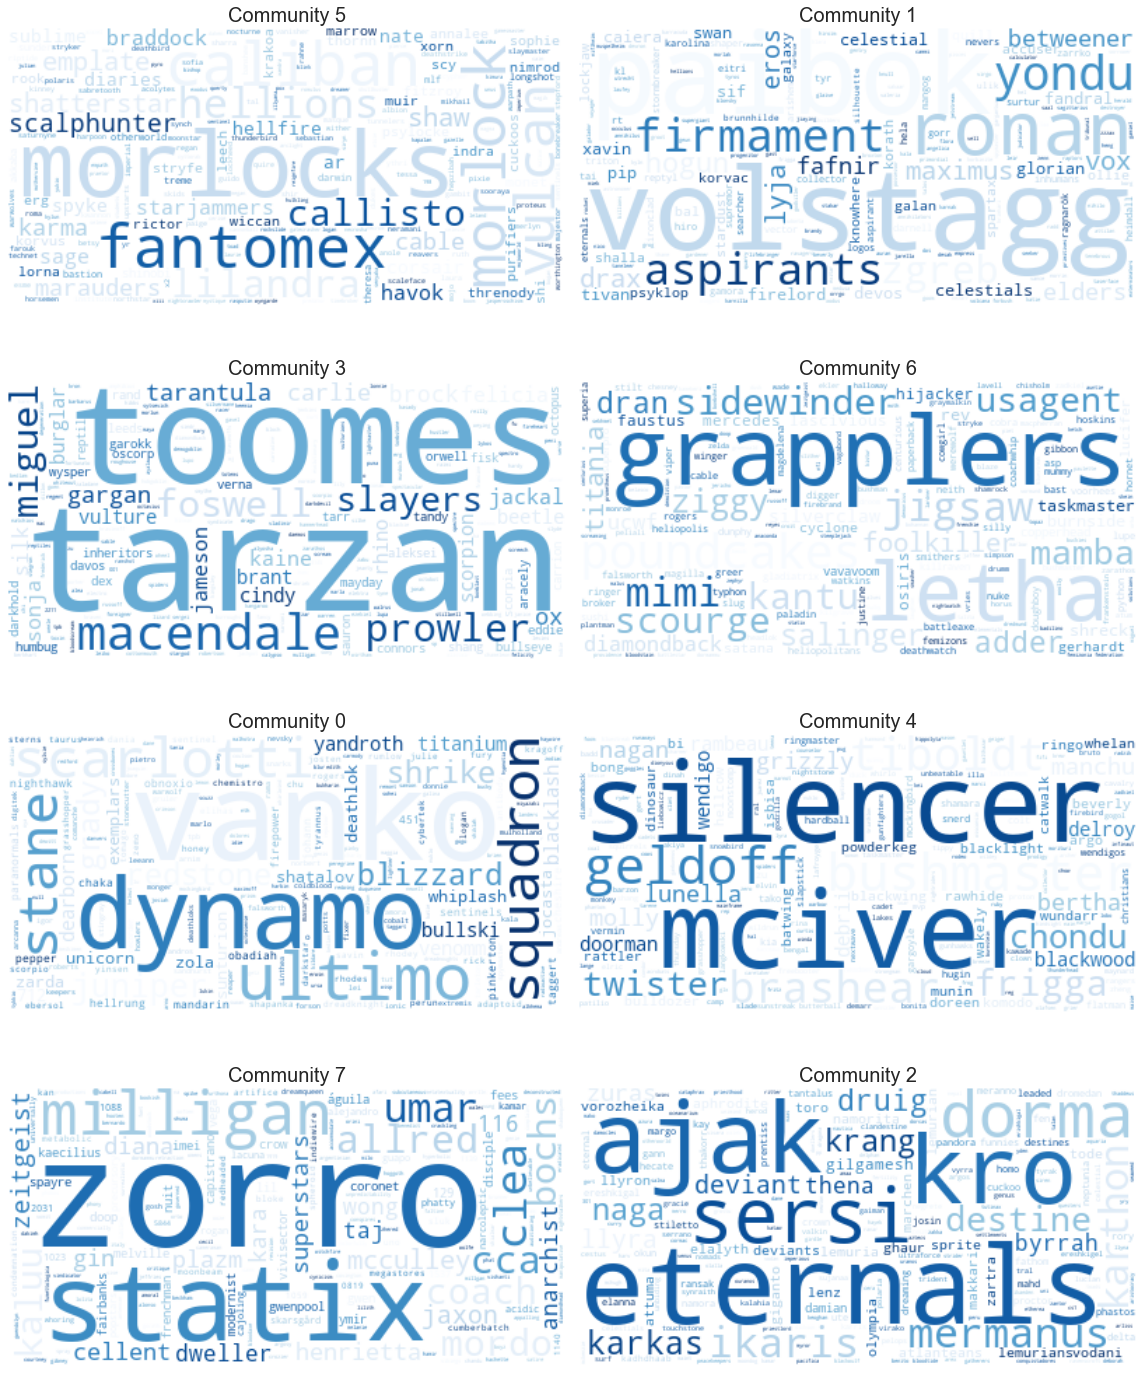

In [43]:
# Initilize plot
fig, axs = plt.subplots(N//2, 2, sharey=True, tight_layout=True, figsize = (16,20))

# Loop over the 8 communities
for p, (com, words) in enumerate(dict(zip(TF_IDF.index, TF_IDF.to_dict(orient = 'records'))).items()):
    import wordcloud # Import wordcloud here due to some bug
    
    # Generate wordcloud
    wordcloud = wordcloud.WordCloud(colormap = "Blues", background_color = "white")
    wordcloud.generate_from_frequencies(frequencies=words)
    
    # Plot it
    axs[p//2, p%2].imshow(wordcloud, interpolation="bilinear")
    axs[p//2, p%2].axis("off")
    axs[p//2, p%2].set_title(f"Community {com}", fontsize = 20)

plt.show()

So what is seen? Firstly it is noticed that many of the larger words (i.e. higher tf-idf values) are names that a casual comic viewer would notive immediatly. This is though exactly the point of the tf-idf; the visualised words are unique to the communities, while many of the large ones from the part 2 word clouds are not seen. This is because of their inverse document frequency that *truncates* them here. A comic fan would probably be able to spot multiple connections between the words in the word clouds. As that is not the case for any in this group it is a bit harder to understand them. It can though be verified that the larger words that corresponds to super heroes (as with Tarzan and Zorro) are in those particular communities. The reason why they are large is then a combination of them not being mentioned in other communities as well as being mention relatively often in their given community.

# Part 4: Sentiment Analysis

In order to do sentiment analysis on the communities, each community is named by its three most connected characters. The most connected characters are determined based on their links in the graph `G_marvel`. The undirected graph is considered so the most connected is based on their overall degree. 

A function `three_most_connected` is created such that the input is a community from the dictionary containing all communities in the Marvel universe. It then calculates the degree of all superheroes in that particular community and returns the three superheroes with the highest degree. So through the analysis, one can use this function to look up the new 'name' of each community. 

In [44]:
def three_most_connected(nodes, full_graph):
    
    # Sub graph for community
    sub_graph = full_graph.subgraph(nodes)
    
    # Get all degrees
    degree_dict = dict(sub_graph.degree(nodes))
    
    # Return three most connected nodes 
    return [node for node, degree in dict(sorted(degree_dict.items(), key = itemgetter(1), reverse = True)[:3]).items()]

The function works with two inputs - namely a list of nodes, along with the graph they originate from. In the context of the problem, the nodes are one of the communities of superheroes and the full graph is the Marvel universe graph i.e. `G_marvel` graph. Here a subgraph is extracted only considering the node as input. From this subgraph the connectivity evaluated. The three most connected nodes are then returned. 

The function is now applied to every community and stored in a dictionary. The dictionary act as a mapping between the "original" name of the community and the three most connected nodes within the community:

In [45]:
# Apply function to all communities
most_connected_heroes = {community: three_most_connected(super_heroes, G_marvel) for community, super_heroes in communities_dict.items()}

# Show results
most_connected_heroes

{0: ['Iron Man', 'Red Skull', 'War Machine'],
 1: ['Hulk', 'Thanos', 'Silver Surfer'],
 2: ['Ikaris', 'Brother Tode', 'Ghaur'],
 3: ['Spider-Man', 'Doctor Octopus', 'Kraven the Hunter'],
 4: ['She-Hulk', 'Howard the Duck', 'Two-Gun Kid'],
 5: ['Professor X', 'Psylocke', 'Scarlet Witch'],
 6: ['Captain America', 'Scourge of the Underworld', 'Punisher'],
 7: ['Doctor Strange', 'Oshtur', 'Vishanti'],
 8: ['Brimstone Love', 'Krystalin', 'La Lunatica'],
 9: ['Rockman', 'Blue Blade', 'Phantom Reporter'],
 10: ['Dionysus'],
 11: ['Flex'],
 12: ['Hephaestus'],
 13: ['Kraken'],
 14: ['Kull'],
 15: ['Nyx'],
 16: ['X-Cutioner', 'Skin', 'Stinger'],
 17: ['Solomon Kane'],
 18: ['Stained Glass Scarlet'],
 19: ['Thunderbolt']}

**Calculate and store sentiment for every single page.**

For the sentiment analysis, Data Set S1 (the LabMT wordlist) from [2] is used. It contains many many words all with a so-called *happiness average* which is used as a sentiment score for that given word. The data set is loaded below:

In [46]:
# Load LabMT wordlist
sentiment_table = pd.read_table('Data/Sentiment.txt', delimiter="\t")
sentiment_table

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332
...,...,...,...,...,...,...,...,...
10217,murder,10218,1.48,1.0150,2762,3110,1541,1059
10218,terrorism,10219,1.48,0.9089,--,--,3192,--
10219,rape,10220,1.44,0.7866,3133,--,4115,2977
10220,suicide,10221,1.30,0.8391,2124,4707,3319,2107


For keeping track of all words in the LabMT wordlist and their corresponding happiness average, data is gathered in a dictionary that maps a word to a score:

In [47]:
sentiment_dict = dict(zip(sentiment_table['word'],sentiment_table['happiness_average']))
sentiment_dict

{'laughter': 8.5,
 'happiness': 8.44,
 'love': 8.42,
 'happy': 8.3,
 'laughed': 8.26,
 'laugh': 8.22,
 'laughing': 8.2,
 'excellent': 8.18,
 'laughs': 8.18,
 'joy': 8.16,
 'successful': 8.16,
 'win': 8.12,
 'rainbow': 8.1,
 'smile': 8.1,
 'won': 8.1,
 'pleasure': 8.08,
 'smiled': 8.08,
 'rainbows': 8.06,
 'winning': 8.04,
 'celebration': 8.02,
 'enjoyed': 8.02,
 'healthy': 8.02,
 'music': 8.02,
 'celebrating': 8.0,
 'congratulations': 8.0,
 'weekend': 8.0,
 'celebrate': 7.98,
 'comedy': 7.98,
 'jokes': 7.98,
 'rich': 7.98,
 'victory': 7.98,
 'christmas': 7.96,
 'free': 7.96,
 'friendship': 7.96,
 'fun': 7.96,
 'holidays': 7.96,
 'loved': 7.96,
 'loves': 7.96,
 'loving': 7.96,
 'beach': 7.94,
 'hahaha': 7.94,
 'kissing': 7.94,
 'sunshine': 7.94,
 'beautiful': 7.92,
 'delicious': 7.92,
 'friends': 7.92,
 'funny': 7.92,
 'outstanding': 7.92,
 'paradise': 7.92,
 'sweetest': 7.92,
 'vacation': 7.92,
 'butterflies': 7.92,
 'freedom': 7.9,
 'flower': 7.88,
 'great': 7.88,
 'sunlight': 7.88,
 

A function `sentimentcalc` is created for calculating sentiment of each word. The function takes a list of tokens as input and look up the sentiment value in the LabMT wordlist. The function returns the average sentiment or `np.nan` if no scores are found. It is seen below:

In [48]:
def sentimentcalc(tokens):
    
    # Get all words with a sentiment score from the token list
    sents = [sentiment_dict[word] for word in tokens if word in sentiment_dict.keys()]
    
    # Return nan if no words have a score
    if len(sents) == 0:
        return np.nan
    
    # Else return the mean of scores
    else:
        return np.mean(sents)

All wiki-texts in the dictionary containing superheros and their corresponding wiki-text, are tokenized into a list and all words are set to lowercase. 

In [49]:
# Tokenize and lower
tokens = {
    super_hero: tokenizer.tokenize(text["Wiki_text"].lower())
    for super_hero, text in super_hero_dict.items()
    if text["Wiki_text"] is not None
}


The sentiment values can then be calculated using the function presented above. 

In [50]:
# Get sentiment value for all super heroes
sentiment_value = {
    super_hero: sentimentcalc(tokens) for super_hero, tokens in tokens.items() if sentimentcalc(tokens) is not np.nan
}

**Create a histogram of all character's associated page-sentiments.**

Now that dictionary, `sentiment_value`, contains all super heroes and their sentiment values so a histogram can be created to get an overview of the values across all super heroes:

In [51]:
np.mean(list(sentiment_value.values()))

5.336042092686079

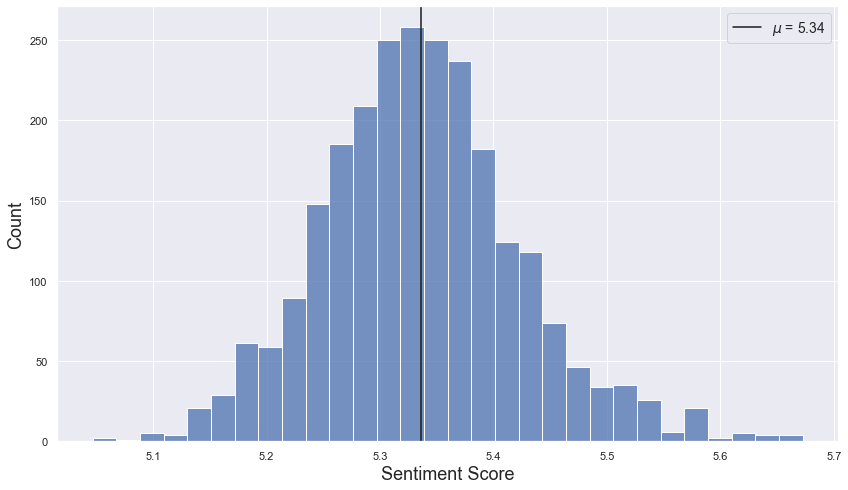

In [52]:
# Plot histogram
plt.figure(figsize = (14,8))
sns.histplot(sentiment_value.values(), bins = 30, color = "tab:blue", legend = False)
plt.xlabel('Sentiment Score', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
# Plot mean
mu = np.mean(list(sentiment_value.values()))
plt.axvline(mu, color = "k")
legend_elements = [Line2D([0], [0], marker=None, color='k', label=fr'$\mu$ = {mu:.2f}')]
plt.legend(handles = legend_elements, loc=1, fontsize = 14)
plt.show()

It is seen that the histogram looks very normal with a mean between of 5.34. All scores fall between 5.0 and 5.7. This corresponds to a very netural to slightly positive language used for all super heroes. The neurality is not surprised as it is wikipedia articles which are predominantly written from an objective perspective. It is though also not unsurprising that some difference is seen as some sentiment words are used. Below the scores of 'super' and 'evil' is shown which is expected to occur fairly frequent in the wiki-articles.

In [53]:
print(sentiment_dict['super'])
print(sentiment_dict['evil'])

7.68
1.9


The usage of these words clearly impact the average score as they are very high and low respectively. Thus it is possible to extract the happiest and saddest pages and communities which is done next.

**What are the 10 characters with happiest and saddest pages?**

The happiest and saddest pages can be determined by sorting the dictionary with the sentiment values in descending and ascending order respectively. There are many superheros in the Marvel universe, so only the 10 characters with happiest and saddest pages are investigated. 

The happiest superheroes are shown below along with their sentiment score:

In [54]:
# Get happiest
dict(sorted(sentiment_value.items(), key = itemgetter(1), reverse = True)[:10])

{'Jack B. Quick II': 5.6726016260162595,
 'Super Rabbit': 5.666722090261284,
 'Super-Turtle': 5.657616707616707,
 'Boone, Daniel': 5.656279069767442,
 'Bebe': 5.6444964028776985,
 'Biff Bronson': 5.642165841584159,
 'Bart Regan': 5.63772068511199,
 'Joanie Swift': 5.635828402366863,
 'Rainbow Girl': 5.628080495356037,
 'Buzzy Brown': 5.621750321750322}

The saddest superheroes are shown below along with their sentiment score:

In [55]:
# Get saddest
dict(sorted(sentiment_value.items(), key = itemgetter(1), reverse = False)[:10])

{'Death Metal': 5.046675257731959,
 'Sin-Eater': 5.062679509632225,
 'Hurricane': 5.082504873294347,
 'Superior': 5.09050185873606,
 'Savage Steel': 5.091127450980393,
 'Death': 5.099054662379421,
 'Clawster': 5.103204225352114,
 'Trash': 5.1047860538827265,
 'Razor Fist': 5.110126582278482,
 'Killer Shrike': 5.111051401869159}

**What are the three happiest communities?**

The sentiment values of each character are stored in a dictionary containing community number as key and the average sentiment of the characters in each community in order to find a community level sentiment. This is done with a dict comprehension as seen below. Here the text is processed as in part 3 - now just not only for the 8 largest communities.

In [56]:
# Get sentiment per community
sentiment_communities = {
    community_key: np.nanmean([sentimentcalc(tokenizer.tokenize(super_hero_dict[super_hero]['Wiki_text'].lower())) 
                   for super_hero in super_heroes if super_hero_dict[super_hero]['Wiki_text'] is not None])
    for community_key, super_heroes  in communities_dict.items()
}

# Show results
sentiment_communities

{0: 5.303609067573169,
 1: 5.317041908508568,
 2: 5.335591613604888,
 3: 5.285788089337912,
 4: 5.331478575763177,
 5: 5.302885797377022,
 6: 5.301591874838268,
 7: 5.3235743013017744,
 8: 5.293019631495868,
 9: 5.3916018852967795,
 10: 5.420921568627451,
 11: 5.313885017421603,
 12: nan,
 13: nan,
 14: 5.386773296244785,
 15: nan,
 16: 5.263915999134012,
 17: 5.366507177033493,
 18: 5.268609550561798,
 19: 5.177392795883362}

The `nan` values occur if none of the charaters have a Wikipage. As it was seen in part 3 those particular communities only had one character why it can be deducted that this character does not have a page.

The three happiest communities are determined in the same way as for the characters. The sentiment values of each community are sorted in descending order and the top three are displayed.

In [57]:
# Get happiest community
dict(sorted(sentiment_communities.items(), key = itemgetter(1), reverse = True)[:3])

{10: 5.420921568627451, 9: 5.3916018852967795, 2: 5.335591613604888}

Based on the naming conventione discussed in the start of part 4 the names of these happy communities are:

In [58]:
print('The three happiest communities are:')
print(most_connected_heroes[10])
print(most_connected_heroes[9])
print(most_connected_heroes[2])

The three happiest communities are:
['Dionysus']
['Rockman', 'Blue Blade', 'Phantom Reporter']
['Ikaris', 'Brother Tode', 'Ghaur']


**What are the three saddest communities?**

Likewise, the three saddest communities are determined by sorting the sentiment values of each community in ascending order.

In [59]:
dict(sorted(sentiment_communities.items(), key = itemgetter(1), reverse = False)[:3])

{19: 5.177392795883362, 16: 5.263915999134012, 18: 5.268609550561798}

In [60]:
print('The three saddest communities are:')
print(most_connected_heroes[19])
print(most_connected_heroes[16])
print(most_connected_heroes[18])

The three saddest communities are:
['Thunderbolt']
['X-Cutioner', 'Skin', 'Stinger']
['Stained Glass Scarlet']


**Do these results confirm what you can learn about each community by skimming the wikipedia pages?**

Looking at the three most happiest and saddest communities respectively, only their names, i.e. the three most connected characters in each community, are considered. 

From the sentiment analysis, it is not surprising that the happiest and saddest communities in general are the ones with one super hero. As more are in a community it tends to approach the mean value. It is therefore interesting to see community 2 (['Ikaris', 'Brother Tode', 'Ghaur']) so *happy* with 43 characters. 

The happiest community only have the character `Dionysus` with wiki-name `Olympians`. The wiki-text is quite short and therefore it is natural that this character will be either in one of the happiest or saddest community. The saddest community with the character `Stained Glass Scarle` contains a wiki-text with a lot of sad words, like abuse, unhappy childhood, and mistreated. Additionally, the wiki-text is not long and therefore these so-called sad words affacts the sentiment value greatly.

A similarity between the majority of the six communities investigated is that they are a part of a group, like the `Thunderbolts` or `Olympians`. This means that their wiki-text is a general text on the whole group and a list of members. This might also be the reason why there are in the top happiest or saddest communities.

As the communities grows larger it becomes more tedious to investigate all articles why the analysis have been stopped here but Marvel or DC fans could probably make sense of the results.

### Sources
[1] Saeidinia, Reza & Barabási, Albert-László. (2017). Network Science: Albert-Laszlo Barabasi
[2] Dodds PS, Harris KD, Kloumann IM, Bliss CA, Danforth CM (2011) Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter. PLoS ONE 6(12): e26752. https://doi.org/10.1371/journal.pone.0026752